In [1]:
from misid_model import *
from scipy.optimize import minimize
import numdifftools as nd
from utility_commonPlot import *

# 1. Perform Template Fit

In [2]:
baseDir = common.getBaseDirectory()
X = np.load(baseDir + "data/misidtemplates/shaping/X_.npy")
Y = np.load(baseDir + "data/misidtemplates/shaping/Y_.npy")
model = PredictiveModel(X)

In [4]:
nsf,ntheta = 12,7+2

# def paramTransformToModel(param):
#     paramsf = np.ones(12)*param[0]
#     prarmtheta = param[1:]
#     paraminput = np.r_[paramsf,prarmtheta]
#     return paraminput
    
def loss (param):
    
    #param = paramTransformToModel(param)
    y = model.predict(param)
    loss  = np.sum( (y-Y)**2/(2*Y) )
    #loss  = np.sum(Y*np.log(y) - y
    loss += np.sum( (param[nsf:]**2)/2  )
    return loss

param0 = np.array([0.98]*nsf + [0]*ntheta)
result = minimize( loss, param0, method='SLSQP', bounds = [(0,2)]*nsf + [(-5,5)]*ntheta )

In [5]:
hcalc = nd.Hessian(loss, step=1e-4, method='central')
hess  = hcalc( result.x )
hessinv = np.linalg.inv(hess)
sig   = np.sqrt(hessinv.diagonal())
cor   = hessinv/np.outer(sig, sig)
loss0 = loss(result.x)

print(result.x)
print(sig)

[ 1.06169456  1.17766117  1.48890141  0.97232713  0.89784237  0.8575195
  0.9765504   0.88082055  0.81818292  0.78959079  0.89652037  0.67297619
 -0.96900681 -0.15400559 -0.00960552  0.21452278  0.38722336  1.05050226
  0.04820765 -1.31047803  1.31489193]
[0.11806781 0.11534484 0.10739837 0.09087671 0.13305252 0.16526171
 0.07893007 0.06402577 0.05873815 0.05291178 0.06003558 0.05395535
 0.85596824 0.99838188 0.9998598  0.67230844 0.68116882 0.98703793
 0.98029013 0.72752649 0.74078185]


In [6]:
ticksPos = [2.5,8.5,12,13,14,15,16,17,18,19,20]
ticksName = [r'SF $ (b \rightarrow \tau_h)$',
             r'SF $ (q \rightarrow \tau_h)$',
             r'$\sigma_{tt}$',
             r'$\sigma_{tw}$',
             r'$\sigma_{W}$',
             r'$\sigma_{Z0}$',
             r'$\sigma_{Z1}$',
             r'$\sigma_{VV}$',
             r'$L$',r'$\epsilon_e$',r'$\epsilon_\mu$',
            ]


# ticksPos = [2.5,6,7,8,9,10,11,12,13,14]
# ticksName = [r'SF $ (jet \rightarrow \tau_h)$',
#              r'$\sigma_{tt}$',
#              r'$\sigma_{tw}$',
#              r'$\sigma_{W}$',
#              r'$\sigma_{Z0}$',
#              r'$\sigma_{Z1}$',
#              r'$\sigma_{VV}$',
#              r'$L$',r'$\epsilon_e$',r'$\epsilon_\mu$',
#             ]

# ticksPos = np.arange(10)
# ticksName = ['SF',
#              r'$\sigma_{tt}$',
#              r'$\sigma_{tw}$',
#              r'$\sigma_{W}$',
#              r'$\sigma_{Z0}$',
#              r'$\sigma_{Z1}$',
#              r'$\sigma_{VV}$',
#              r'$L$',r'$\epsilon_e$',r'$\epsilon_\mu$',
#             ]

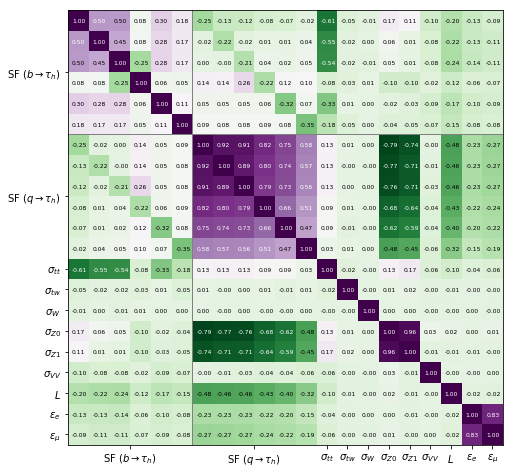

In [7]:
plt.figure(figsize=(8,8),facecolor='w')
plt.imshow(cor,cmap='PRGn_r')
plt.axhline(5.5,color='gray',linewidth=1)
#plt.axhline(11.5,color='gray',linewidth=1)
plt.axvline(5.5,color='gray',linewidth=1)
#plt.axvline(11.5,color='gray',linewidth=1)



plt.xticks(ticksPos,ticksName)
plt.yticks(ticksPos,ticksName)
#plt.colorbar(shrink=0.8)

for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        value = cor[i,j]
#         if abs(value)<0.2:
#             continue
        if abs(value)>0.5:
            fcolor = 'w'
        else:
            fcolor = 'k'
        plt.text(i-0.3,j+0.1,'{:4.2f}'.format(cor[i,j]),fontsize=6,color=fcolor )

plt.savefig('../../plots/misid/corr2',dpi=300)

# 2. Plot Post-fit Templates

In [8]:
param_opt = result.x
#param_opt = paramTransformToModel(result.x)

temp = np.concatenate(model.predict(param_opt,True),axis=1)
targ = np.concatenate(Y,axis=0)
# separate processes
mctt = np.sum(temp[0:5],axis=0)
mct  = np.sum(temp[5:10],axis=0)
mcw  = np.sum(temp[10:15],axis=0)
mcz  = np.sum(temp[15:20],axis=0)
mcvv = np.sum(temp[20:25],axis=0)

mclist = [mcvv,mcz,mcw,mct,mctt]

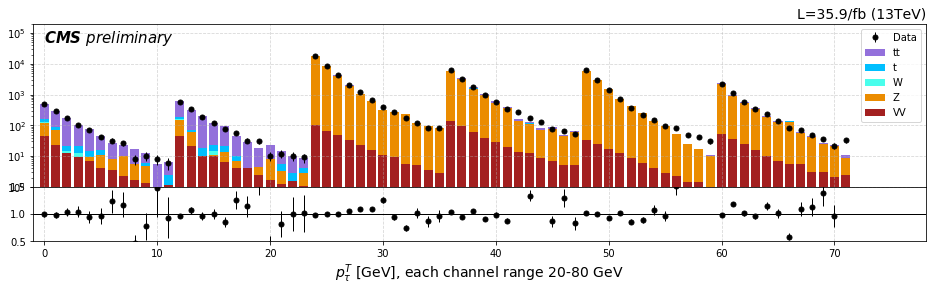

In [13]:
colorList = ["#a32020","#eb8c00","#49feec","deepskyblue","mediumpurple"]
labelList = ["VV","Z","W","t","tt"]
chList = common.channelLsit()


fig, axes = plt.subplots(2, 1, sharex=True, facecolor='w',
                         gridspec_kw={'height_ratios':[3,1]},
                         figsize=(16,4))
fig.subplots_adjust(hspace=0)


c = np.arange(targ.size)
accum = np.zeros(targ.size)

# making plot

ax = axes[0]
for i in range(len(mclist)):
    height = mclist[i]
    ax.bar(c, height, bottom=accum, width=0.8, alpha=1, color=colorList[i],label=labelList[i])
    accum += height
ax.errorbar(c, targ,yerr=targ**0.5, c='k', fmt='.',markersize=10,lw=1, label='Data')
ax.grid(True,linestyle="--",alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_yscale('log')
ax.set_ylim(1,2e5)
ax.text(0, 5e4, r'CMS $preliminary$',style="italic",fontsize="15",fontweight='bold')
ax.set_title("L=35.9/fb (13TeV)",loc="right",fontsize=14)

ax = axes[1]
ax.errorbar(c, targ/accum, yerr=targ**0.5/accum, c='k', fmt='.',markersize=10,lw=1)
ax.grid(True,linestyle="--",alpha=0.5)
ax.axhline(1,lw=1,color='k')
ax.set_ylim(0.5,1.5)
ax.set_xlim(c.min()-1., 1.1*c.max())
ax.set_xlabel(r'$p^T_\tau$ [GeV], each channel range 20-80 GeV',fontsize=14)

plt.savefig('../../plots/misid/tauID_postfit',dpi=300)

# Show the fitting Results

In [9]:
c_sf = result.x[:nsf].reshape(2,6)
s_sf = sig[:nsf].reshape(2,6)
ptpos = np.array([22.5,27.5,35,45,57.5,72.5])
ptwid = np.array([2.5,2.5,5,5,7.5,7.5])
c_sfjet = array([1.02679732 , 0.96569836,  0.96703374,  0.90160079,  0.91602756,  0.72227627])
s_sfjet = array([0.05489577, 0.04604289, 0.04418809, 0.04149803, 0.04437043, 0.04330899])
#c_sfjet = array([1.01831573, 0.96135078, 0.9429135 , 0.88707892, 0.93013478, 0.70739701])
#s_sfjet = array([0.05479143, 0.04606   , 0.04338468, 0.04102377, 0.04481317,0.04184311])

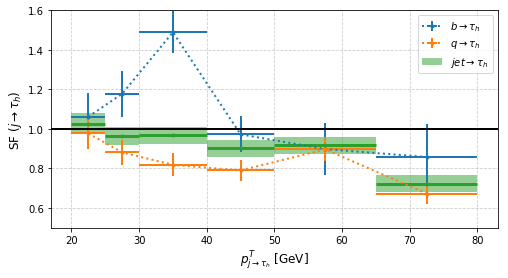

In [10]:
plt.figure(figsize=(8,4),facecolor='w')

plt.errorbar(ptpos,c_sf[0],xerr=ptwid,yerr=s_sf[0],
             fmt='.:', lw=2, color='C0',alpha=1,
             label=r'$b \rightarrow \tau_h$')
plt.errorbar(ptpos,c_sf[1],xerr=ptwid,yerr=s_sf[1],
             fmt='.:', lw=2, color='C1',alpha=1,
             label=r'$q \rightarrow \tau_h$')

plt.bar(ptpos,2*s_sfjet,bottom=c_sfjet-s_sfjet,width=2*ptwid,
        color='C2',alpha=0.5,
        label=r'$jet \rightarrow \tau_h$')

plt.errorbar(ptpos,c_sfjet,xerr=ptwid,
             fmt='.', lw=3, color='C2',alpha=1)



plt.axhline(1,color='k',linewidth=2)

plt.grid(linestyle='--',color='grey',alpha=0.4)
plt.legend()
plt.xlabel(r'$p^T_{j\rightarrow \tau_h}$ [GeV]',fontsize=12)
plt.ylabel(r'SF $ (j\rightarrow \tau_h)$',fontsize=12)
plt.ylim([0.5,1.6])
plt.savefig('../../plots/misid/fit_ptflavor.png',dpi=300)

In [11]:
d = {'bin_pT1': ptpos - ptwid, 
     'bin_pT2': ptpos + ptwid,
     'SF_b2MisID':c_sf[0],
     'SF_q2MisID':c_sf[0],
     'SF_j2MisID':c_sfjet,
     'sigma_SF_b2MisID':s_sf[0],
     'sigma_SF_q2MisID':s_sf[1],
     'sigma_SF_j2MisID':s_sfjet
    }
df = pd.DataFrame(data=d)
df.to_csv('SF_misID.csv')

In [12]:
print('b -> tau')
for i in range(6):
    print('{:4.2f}+/-{:4.2f}'.format(c_sf[0,i],s_sf[0,i]))

print('q -> tau')
for i in range(6):
    print('{:4.2f}+/-{:4.2f}'.format(c_sf[1,i],s_sf[1,i]))
    
print('jet -> tau')
for i in range(6):
    print('{:4.2f}+/-{:4.2f}'.format(c_sfjet[i],s_sfjet[i]))

b -> tau
1.06+/-0.12
1.18+/-0.12
1.49+/-0.11
0.97+/-0.09
0.90+/-0.13
0.86+/-0.17
q -> tau
0.98+/-0.08
0.88+/-0.06
0.82+/-0.06
0.79+/-0.05
0.90+/-0.06
0.67+/-0.05
jet -> tau
1.03+/-0.05
0.97+/-0.05
0.97+/-0.04
0.90+/-0.04
0.92+/-0.04
0.72+/-0.04
